# 0. Import Python libraries

In [1]:
#math
import numpy as np
import sympy as sy
#vis
import matplotlib.pyplot as plt

# 1. $f$, $\nabla f$ and $\nabla^2 f$ definition

In [2]:
"""This section enables to express f (objective function), its gradient vector and hessian matrix symbolically and evaluate them at specific coordinates.
To do so, express analititically f by indexing the symbolic variable x. For instance x[0] represent first dimension, x[1] the second and so on.
grad_f_exp and hess_f_exp are only there to automatically differentiate f_exp. To evaluate the f, grad_f or hess_f functions, call them precising the desirated coordinates.
This evaluation use lambdify function and uses "numpy" format.

    Parameters
    ----------
    x : sympy.IndexedBase
        symbolic variable managing indexes. For instance, instead of declaring n variable for the n dimensions (x, y, z, ...) which isn't easily scalable, 
        here variables are automaticly indexed (x_1, x_2, ..., x_n).

    xk : np.array (float)
        Coordinates to evaluate the function.

    Returns
    -------
    numpy.float (scalar or numpy.array)
        Depending on the considered function, return a scalar, a (n, ) vector or a (n, n) array.

    Notes
    ------
    The use of specific function to express f, grad_f and hess_f is to improve scalability in the case of not having analitic expression.
    For instance, when only have a black box model which evaluate f, grad_f (and hess_f). 

    References
    ------
    https://docs.sympy.org/latest/index.html

    Examples
    ------
    >>>x = sy.IndexedBase('x')
    >>>xk = [-4, 3]
    >>>dk = grad_f(x, xk)
    """

def f_exp(x):
    return 3*x[0]**2 + 2*x[1]**2 + 20*sy.cos(x[0])*sy.cos(x[1])+40

def f(x, xk):
    return sy.lambdify(x, f_exp(x), "numpy")(xk)

def grad_f_exp(x, xk):
    return [sy.diff(f_exp(x), x[i]) for i in range(len(xk))]

def grad_f(x, xk):
    lambdify = [sy.lambdify(x, gf, "numpy") for gf in grad_f_exp(x, xk)]
    return np.array([lambdify[i](xk) for i in range(len(xk))])

def hess_f_exp(x, xk):
    return [[sy.diff(g, x[i]) for i in range(len(xk))] for g in grad_f_exp(x, xk)]

def hess_f(x, xk):
    lambdify = [[sy.lambdify(x, gf, "numpy") for gf in Hs] for Hs in hess_f_exp(x, xk)]
    return np.array([[lambdify[i][j](xk) for i in range(len(xk))] for j in range(len(xk))])

# 2. Wolfe conditions

In [3]:
class Wolfe():
    """Wolfe is a class implementing the Wolfe's conditions using a bissection method. It has 4 functions in addition to the __init__ function.
    - fit(): is the main function, ensuring the convergency and implementing the bissection algorithm. It calls phi(), phi_grad() and theta() 
    - phi(): is the function to evaluate the first terme of Wolfe's condition. It calls the function f() previously defined by the user.
    - phi_grad(): is the function to evaluate the first terme of Wolfe's condition. It calls the function grad_f() previously defined by the user.
    - theta(): is the function to evaluate the second terme of Wolfe's condition. It calls the functions f() and grad_f() previously defined by the user.

    Notes
    ------
    The class respect a commun pattern for all line search classes. To evaluate descent step call the function fit().

    References
    ------
    J. F. Bonnans, J. C. Gilbert, C. Lemaréchal, C. A. Sagastizábal, 2006. Numerical Optimization: Theoretical and Practical Aspects. https://doi.org/10.5860/choice.41-0357
    https://github.com/scikit-learn/scikit-learn

    Examples
    ------
    >>>goldsteinlinesearch = Goldstein(x, xk, dk, w_1=w_1, w_2=w_2, a_max=a_max, max_it=max_it)
    >>>it, a = goldsteinlinesearch.fit()
    """
    def __init__(
        self,
        x,
        xk,
        dk,
        *,
        w_1=.15,
        w_2=.5,
        a_max=15,
        max_it=50
        ):
        """
        Parameters
        ----------
        x : sympy.IndexedBase
            Previously defined, needed to evaluate phi() and theta()
        xk : np.array (float)
            Coordinates to evaluate the function
        dk : np.array (float)
            direction descent at iteration k
        w_1 : float, optional
            hyperparameter defining Wolfe's first condition, by default .15
        w_2 : float, optional
            hyperparameter defining Wolfe's second condition, by default .5
        a_max : int, optional
            hyperparameter defining maximum step size, by default 15
        max_it : int, optional
            hyperparameter defining maximum of iteration, by default 50
        """
        self.x = x
        self.xk = xk
        self.dk = dk
        self.w_1 = w_1
        self.w_2 = w_2
        self.a_r = a_max
        self.a_l = 0
        self.max_it = max_it
        
    def phi(Wolfe, a):
        phi = f(Wolfe.x, Wolfe.xk + a * Wolfe.dk)
        return phi
    
    def phi_grad(Wolfe, a):
        phi_grad = np.dot(grad_f(Wolfe.x, Wolfe.xk + a*Wolfe.dk), Wolfe.dk)
        return phi_grad

    def theta(Wolfe, a):
        theta = f(Wolfe.x, Wolfe.xk) + Wolfe.w_1 * a * np.dot(grad_f(Wolfe.x, Wolfe.xk), Wolfe.dk)
        return theta

    def fit(Wolfe):
        """
        Calculate a the mean of a window ([a_l, a_r]) and check if c1 is met. If not, shrink the window from the right.
        Then check if c2 is met, if so break, if not, depending on the value (positive or negative of phi_grad(a)) shrink the window from the right or the left.

        Returns
        -------
        list(int, float): [it, a]
            Returns both iteration steps needed and a respecting Goldstein's rule step.

        """
        it = 0
        c1 = Wolfe.phi(Wolfe.a_l)
        c2 = Wolfe.w_2*Wolfe.phi_grad(0)
        
        while(it <= Wolfe.max_it):
            a = (Wolfe.a_l + Wolfe.a_r)/2
            if Wolfe.phi(a) > Wolfe.theta(a) or Wolfe.phi(a) >= c1:
                Wolfe.a_r = a
            else:
                if np.abs(Wolfe.phi_grad(a)) <= - c2:
                    print(f'stop it: {it + 1}')
                    break
                else:
                    if (Wolfe.phi_grad(a) > 0):
                        Wolfe.a_r = a       
                    else:
                        Wolfe.a_l = a
                        c1 = Wolfe.phi(Wolfe.a_l)
            it += 1
            if(it==Wolfe.max_it):
                print(it)
                print('a n\'a pas convergé')
        return [it, a]

In [4]:
#symbolic variable definition
x = sy.IndexedBase('x')

#Wolfe hyperparameters
w_1 = .15
w_2 = .5
a_max = 12
max_it = 10

#Wolfe input
xk = [-4, 3]
dk = - grad_f(x, xk)/np.linalg.norm(grad_f(x, xk))

#Wolfe fit
wolfelinesearch = Wolfe(x, xk, dk, w_1=w_1, w_2=w_2, a_max=a_max, max_it=max_it)
it, a = wolfelinesearch.fit()

#print output
print(f"alpha: {a}")
print(f"dk: {dk}")

stop it: 4
alpha: 6.75
dk: [ 0.54568069 -0.83799319]


# 3. Visualization

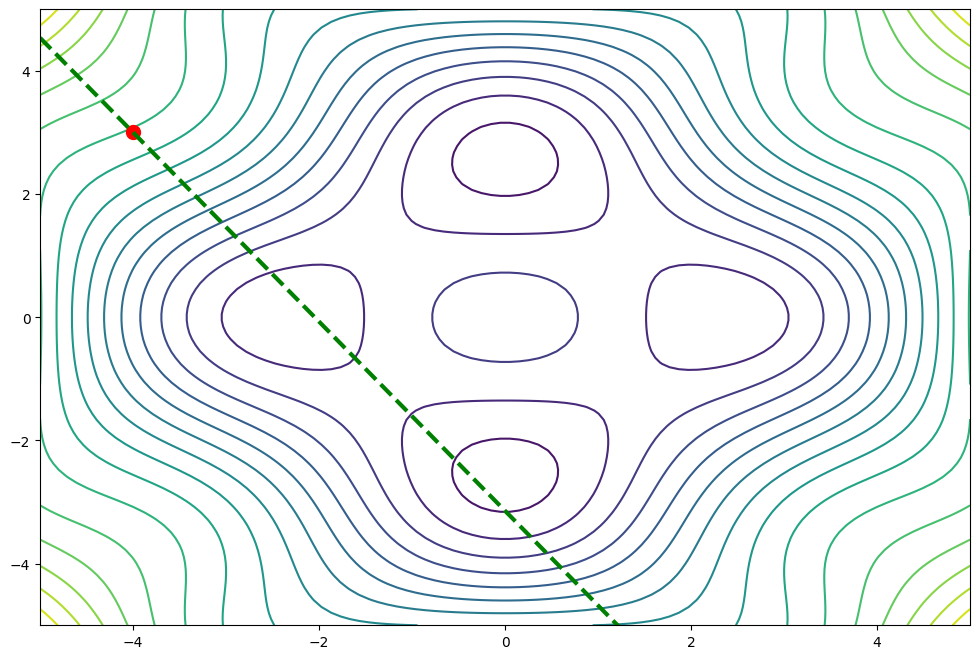

In [5]:
#Create meshgrid
X = np.linspace(-5, 5, 100)
Y = np.linspace(-5, 5, 100)
mesh_X, mesh_Y = np.meshgrid(X, Y)
Z = f(x,[mesh_X,mesh_Y])

#Choose which dimensions to plot
xdim = 0
ydim = 1

#Calculate direction search at xk
d = (dk[ydim]/dk[xdim])*(X-xk[xdim]) + xk[ydim]

#plot figure
plt.figure(figsize=(12, 8))
plt.ylim(-5, 5)
plt.xlim(-5, 5)
plt.contour(mesh_X, mesh_Y, Z, 16)
plt.plot(xk[xdim], xk[ydim], 'or', markersize= 10)
plt.plot(X, d, 'g--', linewidth=3)
plt.show()

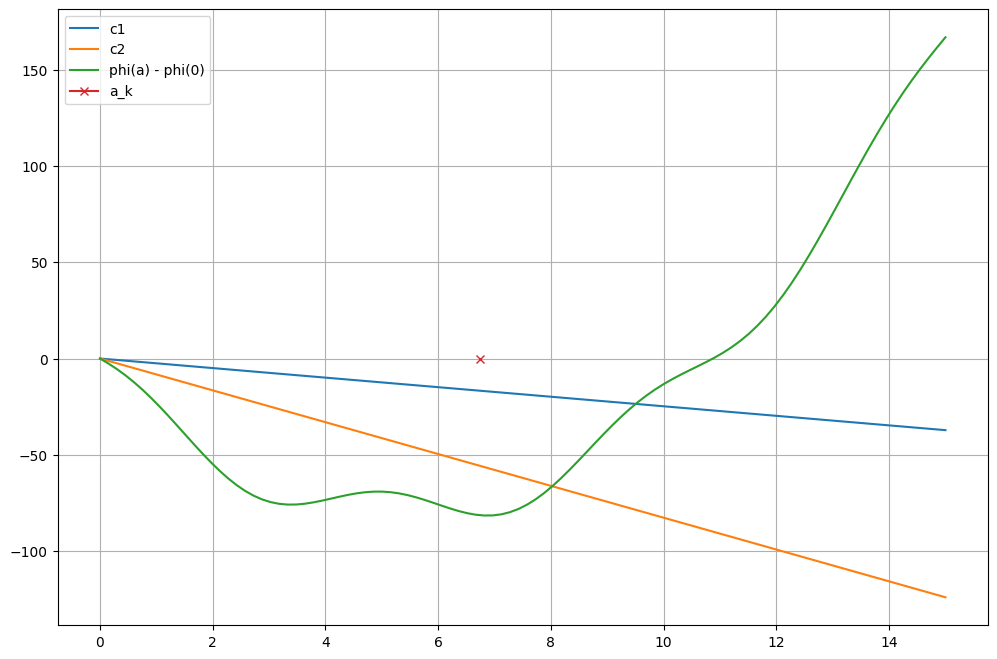

In [6]:
X= np.linspace(0, 15, 100)

#first condition
c1= w_1*np.dot(grad_f(x, xk), dk)*X
#second conditon
c2 = w_2*np.dot(grad_f(x, xk), dk)*X
#descent response of line search
phi = [f(x, xk + i*dk) - f(x, xk) for i in X]
#convergence of a
xa = [a]

#plot figure
plt.figure(figsize=(12, 8))
plt.grid(visible=True)
plt.plot(X, c1)
plt.plot(X, c2)
plt.plot(X, phi)
plt.plot(xa, np.zeros(len(xa)), marker='x')
plt.legend(['c1' , 'c2', 'phi(a) - phi(0)', 'a_k'])
plt.show()